<a href="https://colab.research.google.com/github/sahooamarjeet/Machine-Learning-using-Python/blob/master/Practical_Issues_In_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Issues in Machine Learning

## Overview

The presentation before this notebook looked at how to frame a data science project. In this notebook, we will briefly review the problem, the metric, and potential design issues we should consider. The focus will be on writing code that deals with features robustly.

Python's scikit-learn library makes building a machine learning model simply with a consistent interface: create the model, fit the model, and score the model. The difficult parts of modeling are ensuring that the preprocessing steps are done consistently, metrics for scoring are chosen appropriately, features are engineered to capture the nuance in the data.

I will go through three problems that illustrate things I am interested in:

- **Predicting rents on individual houses (feature selection)**

  - Limitations of feature importance as implemented in Random Forests
  - Permutation importance as a substitude

  - _References:_
    - Blog post on [feature importances](https://explained.ai/rf-importance/)
    
- **Loan default prediction (classification)**
  
  - Data Leakage, preparation, and problem framing
  - Dealing with categorical variables
  - Probability calibration
  - Is classification the right approach?
  
  - _References_
    - Blog post on [using ColumnTransformer](https://kiwidamien.github.io/introducing-the-column-transformer.html)
    - Blog post on [probability scaling](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html)
    - Blog post on [encoding categorical variables](https://kiwidamien.github.io/encoding-categorical-variables.html), and the [James Stein encoder](https://kiwidamien.github.io/james-stein-encoder.html)
    - Blog post on [Pipelines]
    
Here is an additional exercise that we will not have time to cover today, but looks at doing predictions on aggregate statistics:

- **Predicting the median house price on a block (regression)**

  - Blog post on [Custom scoring vs custom loss](https://kiwidamien.github.io/custom-loss-vs-custom-scoring.html)

  



## My Assumptions about you

This talk is part of the _practioner_ track. I assume that you are familiar with the building models in sklearn. 

The goal is to talk through certain issues and show code that you can use as a template for your own approach. Certain code, such as plotting functions, will be given without a lot of detail. The best approach for a technical workshop is to pick up the big ideas, and follow what the code is doing at a high level.


* It helps if you are familiar with the scikit-learn API, but this talk is also a good way to pick it up
* I do assume you have been exposed to the concepts of 
  * Standard scaling data
  * Cross validation
  *  Fitting, predicting and scoring data
  
  although this experience might come from other software packages

## Scikit-learn API

Hopefully everyone is familiar with the sklearn API. One of the strengths of sklearn is how consistent the API is, so that for each model we can start implementing it knowing only the basic hyperparameters.


#### Known hyperparameters



As a reminder, an sklean `Model` with hyperparameters `params` can be implemented with
```python
# Model can be LinearRegression, Lasso, RandomForestClassifier, NaiveBayesClassifier, .....
from sklearn.X import Model

# Get the desired metric, here we use r2_score
from sklearn.metrics import r2_score

.....
# import data, split into train test sets, etc
.....

params = {
   'param1': value1,
   'param2': value2,
    .....
}

mymodel = Model(**params).fit(X_train, y_train)

# make predictions, for classification problems
# mymodel.predict_proba is also useful
predict_train = mymodel.predict(X_train)
predict_test = mymodel.predict(X_test)

#get scores
training_score = r2_score(y_train, predict_train)
test_score = r2_score(y_test, predict_test)
```

#### Grid search hyperparameters



Often we will want to search for the right hyperparameters to use
```python
# Model can be LinearRegression, Lasso, RandomForestClassifier, NaiveBayesClassifier, .....
from sklearn.X import Model

# Get the desired metric, here we use r2_score
from sklearn.metrics import r2_score

.....
# import data, split into train test sets, etc
.....

params = {
   'param1': [v1_for_p1_to_try, v2_for_p1_to_try, ....., vN_for_p1_to_try],
   'param2': [v1_for_p2_to_try, v2_for_p2_to_try, ....., vN_for_p2_to_try],
    .....
}

mymodel = GridSearchCV(Model(), param_grid=params, cv=5, random_state=42).fit(X_train, y_train)

# make predictions, for classification problems
# mymodel.predict_proba is also useful
predict_train = mymodel.predict(X_train)
predict_test = mymodel.predict(X_test)

#get scores
training_score = r2_score(y_train, predict_train)
test_score = r2_score(y_test, predict_test)
```

# Imports

Our first problem will look at _permutation importance_. Originally the discussion was going to be on how to implement permutation importance, but a recent development version of sklearn (merged July 18th) includes it.

The cell below takes a while to run (up to 10 minutes). If the kernel dies and you have to rerun the notebook, you can skip this cell. We have implemented a backup version using `mlxtend`'s implementation.

In [0]:
#!pip install git+https://github.com/scikit-learn/scikit-learn.git

In [0]:
!pip install category_encoders

In [0]:
import category_encoders as ce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import california_housing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import pandas_profiling as pdprofile

%matplotlib inline

try:
  from sklearn.inspection import permutation_importance
except ImportError:
  print("Problem importing permutation_importance -- patching")
  from mlxtend.evaluate import feature_importance_permutation
  def permutation_importance(estimator, X, y, scoring='r2', n_repeats=5):
    """Use mlxtend function, but give the same interface as the upcoming
       function merged into the 0.22.dev branch of scikit-learn.
    """
    # match the arguments for the new function to the mlxtend function
    means, values = feature_importance_permutation(X.values, y, estimator.predict, scoring, num_rounds=n_repeats)
    return {
        'importances': values,
        'importances_mean': means
    }

Problem importing permutation_importance -- patching


# Problem 1. The Danger Of Feature Importance

If we have many features, it is generally good practice to build a _simple_ model that is
- quick to train
- has a notion of feature importance

This allows us to determine which features are important before moving on to more complicated models that are more expensive to train. The typical candidates are
* __Lasso:__ Sets unimportant coefficients to zero, and we can access the coefficients (after scaling) as a rough guide as to which features are important
* __Random forests__: Doesn't require much preprocessing, and has an explicitly named `feature_importances_` attribute to determine the relative importance of different features.

An excellent [article](https://explained.ai/rf-importance/) shows how `feature_importances_` can be misleading. The general idea of using a simple model to evaluate the value of a feature is still a good one, but feature importance can be a misleading metric. 

Let's see how on a dataset were we try and predict the rental price of a house based on some simple features:

In [0]:
rent_url = 'https://raw.githubusercontent.com/parrt/random-forest-importances/master/notebooks/data/rent.csv'
rent_df = pd.read_csv(rent_url)
print(f'Dataset has {rent_df.shape[0]} rows')
rent_df.head()

Dataset has 49352 rows


,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1
2,1.0,1,2850,-74.0018,40.7388,3
3,1.0,1,3275,-73.9677,40.7539,1
4,1.0,4,3350,-73.9493,40.8241,1


In this acse we have 5 features, and they are all numerical. 

**Note** We typically wouldn't worry about feature elimination too much in a dataset with only 5 features and 40k rows. This is more an example of how the feature importance can fail to be a good metric.

## Quick EDA

Let's have a quick look at the dataset:

---



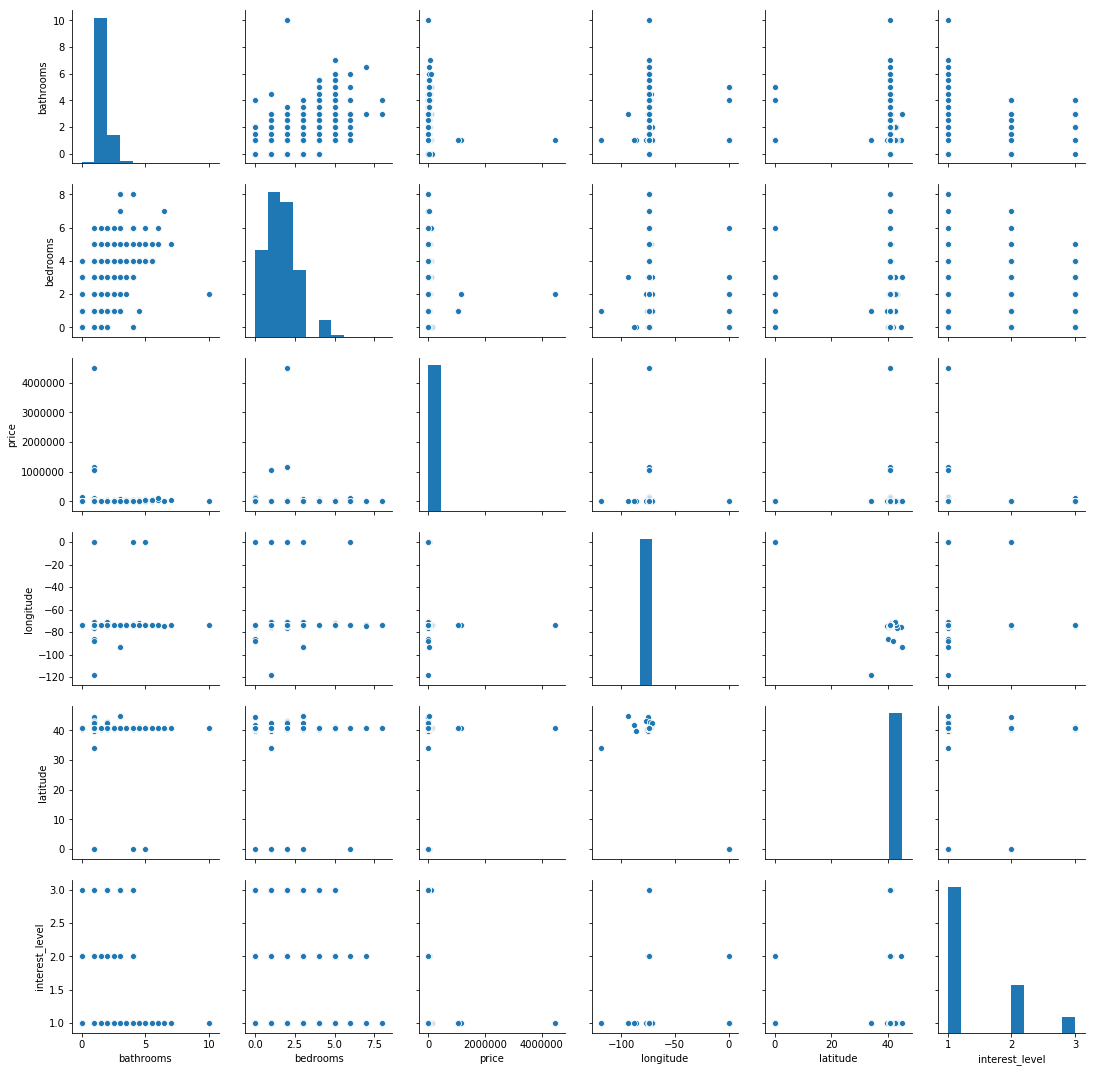

In [0]:
sns.pairplot(rent_df)

Things to notice:
- We seem to have some longitudes and latitudes around 0. These are almost certainly missing values. Our latitudes tend to be around $+40^\circ$ and out longitudes tend to be around $-80^\circ$. This puts us in the area for NYC. If this were a proper model or Lasso, we would have to correct for that; for trees these few points shouldn't make a large difference.
- The number of bathrooms is very tightly clustered; bedrooms less so.
- The interest level is essentially categorical
- The price is heavily skewed, with an outlier around the 4 million dollar mark




In [0]:
features_train, feature_test, price_train, price_test = train_test_split(rent_df.drop('price', axis=1), rent_df['price'])

params = {
    'n_estimators': [100],
    'max_depth': [2, 3, 4],
    'min_samples_split': [10, 20]
}

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=5).fit(features_train, np.log(price_train))

In [0]:
rf_grid.best_score_, rf_grid.best_params_

(0.6539809219468894,
 {'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 100})

We might be able to get a better $R^2$ with a more sophisticated model (or, more likely, including more features). Let's see how the importance of the different features ranked.

In [0]:
|plot_frame = pd.DataFrame(zip(rf_grid.best_estimator_.feature_importances_, features_train.columns),
                          columns=['value', 'feature'])
plot_frame.sort_values('value').plot.barh(x='feature', legend=None);

SyntaxError: ignored

This predicts that the `interest_level` and `latitude` are not important, while the number of bathrooms is very important!  

Let's set the interest level of everyone to 3 and see how the predictions change:

34148
New R^2 is 0.45351145508343926


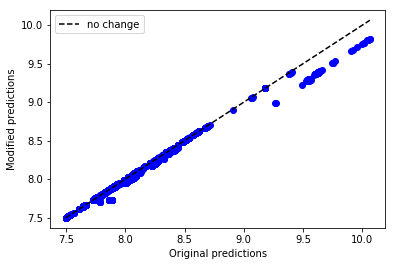

In [0]:
def plot_predictions(model, features_post_change,
                     features_pre_change=features_train):
  orig_prediction = model.predict(features_pre_change)
  mod_prediction = model.predict(features_post_change)
  min_orig, max_orig = min(orig_prediction), max(orig_prediction)
  
  # don't show rows that match on every feature
  # not informative amount change
  has_change = ((features_pre_change != features_post_change).sum(axis=1) > 0)
  print(sum(has_change))
  plt.plot(orig_prediction[has_change], mod_prediction[has_change], 'bo')
  plt.plot([min_orig, max_orig], [min_orig, max_orig], 'k--', 
           label='no change')
  plt.xlabel('Original predictions')
  plt.ylabel('Modified predictions')
  plt.legend()
  
features_train_mod = features_train.copy()
features_train_mod['interest_level'] = 3
mod_predictions = rf_grid.predict(features_train_mod)

plot_predictions(rf_grid, features_train_mod)
new_r_squared = r2_score(mod_predictions, np.log(price_train))
print(f"New R^2 is {new_r_squared}")

## What is this telling us?

We see a feature that wasn't supposed to have an effect is actually important! Some important things to note:
* __Not Overfitting__

  We did not retrain the model, nor did we apply the model to hold out data. We applied it to training data, after changing a feature we were told was unimportant
* __Only a few points?__

  The $R^2$ dropped significantly when applied to the modified data. This isn't just a case of a few points looking bad due to overplotting!
  
* __Feature importances are normalized to 1, maybe all other features are worse?__
  
   This is a reasonable objection -- maybe if I altered any _other_ feature I would see a larger drop in $R^2$. We will look at this next.

## Adding a random feature

Let's add a completely non-informative feature and determine its importance

In [0]:
features_train['random'] = np.random.normal(size=len(features_train))

Let's retrain the model with this completely random feature added on:

In [0]:
params = {
    'n_estimators': [100],
    #'max_depth': [2, 3, 4],
    'min_samples_split': [5]
}

rf_grid2 = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=5).fit(features_train, np.log(price_train))

Best score on holdout set is 0.8441106576992047


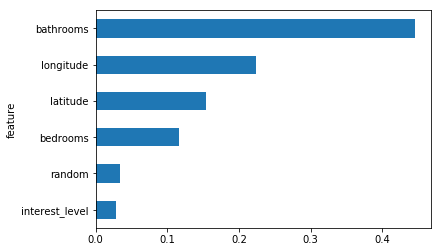

In [0]:
print(f'Best score on holdout set is {rf_grid2.best_score_}')

plot_frame = pd.DataFrame(zip(rf_grid2.best_estimator_.feature_importances_, features_train.columns),
                          columns=['value', 'feature'])
plot_frame.sort_values('value').plot.barh(x='feature', legend=None);

In [0]:
rf_grid2.best_estimator_.feature_importances_

array([0.4448888 , 0.11611334, 0.22318048, 0.15357581, 0.02771562,
       0.03452594])

In [0]:
perm_importance = permutation_importance(rf_grid2, features_train, np.log(price_train))
perm_importance

{'importances': array([[0.43682825, 0.4416178 , 0.43107764, 0.43922333, 0.43394873],
        [0.55459697, 0.55610432, 0.55350917, 0.54587703, 0.5558264 ],
        [0.51879868, 0.52427453, 0.51892659, 0.51566162, 0.5163084 ],
        [0.41392685, 0.41682333, 0.41244429, 0.41347785, 0.41392575],
        [0.11998686, 0.10222463, 0.10352208, 0.10319377, 0.11057094],
        [0.03286173, 0.03379164, 0.03409438, 0.03301106, 0.03414442]]),
 'importances_mean': array([0.43653915, 0.55318278, 0.51879396, 0.41411961, 0.10789966,
        0.03358065])}

In [0]:
# Compare like with like and normalize the permutation importances
plot_frame = pd.DataFrame({
    'feature': features_train.columns,
    'importances_': rf_grid2.best_estimator_.feature_importances_,
    'permutation': perm_importance['importances_mean']/perm_importance['importances_mean'].sum()
})
plot_frame

,feature,importances_,permutation
0,bathrooms,0.443954,0.211490
1,bedrooms,0.119565,0.268000
2,longitude,0.226350,0.251340
3,latitude,0.149349,0.200628
4,interest_level,0.028054,0.052274
5,random,0.032728,0.016269


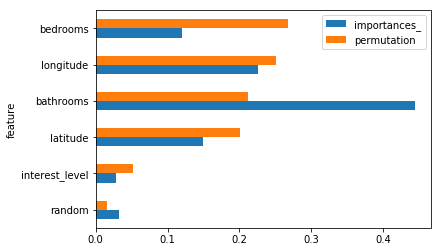

In [0]:
plot_frame.sort_values('permutation').plot.barh(x='feature');

We see permutation importance weighs `longitude`,  `bedrooms`,  `bathrooms` and `latitude` reasonably evenly, unlike the default feature importances.

### Why is this happening?

The default feature importance is described [here](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)

>1.  Initialize an array feature_importances of all zeros with size `n_features`.
>
>2. traverse the tree: for each internal node that splits on feature `i` you compute the error reduction of that node multiplied by the number of samples that were routed to the node and add this quantity to `feature_importances[i]`.

i.e. feature importances are calculated in a similar greedy manner as the splits.

For a feature like number of bathrooms, we have only a few values, so a split here separates a lot of points. This means it is likely to be a split near the top of the tree, and get a lot of importance.

You have to worry about this when
* __you have a categorical feature with lots of (one hot encoded) levels__
  
  Trees don't like splitting on features that take the same value over most of the data set. Feature importance will typically be _under-estimated_ for these features/levels.
  
* __you have a numerical feature or lots of numerical levels__

  If a tree can put a split into a single list of (ordered) categories, this feature will appear frequently at the top of trees, and its feature important will be _inflated_.
  
Consider ZIP codes:
* If you treat the ZIP codes as numbers (90210, 95616, ....) then they will be ordered, and lots of splits can be found that reduce error, and there will be a lot of samples on either side of the split. We have `feature_importance` will be inflated.
* If you one hot encode ZIP codes, then trees rarely pick them as only a small fraction of data lies in any particular zip code. This will tend to _underemphasize_ the feature.

A permutation importance instead _shuffles_ the data in each column, and measures the change in our metric. If a feature is truly unimportant to the final prediction, then shuffling the values should not matter because the feature is unimportant. Note that we don't need to retrain the model, and that a permutation test can be applied to _any_ model to gauge the importance of a feature.

## Summary

* `RandomForest` is a great model for getting a baseline and assessing which features are important.
* However the default `feature_importances_` are misleading, and are particularly biased against unordered categorical variables (and biased toward continuous variables)
* Permutation importance can be used instead -- not _quite_ in production scikit-learn, but it is in the development branch (as of July 18th!). An implementation in `mlxtend` is currently available.


**Things we didn't talk about, but good to address**

* Don't use all features -- too easy to find spurious correlations! 

  In this example, we are not worried (5 features, ~40k examples)
* There are other alternatives, such as Recurrsive Feature Selection, that can also help par down features to a "useful" subset. This is probably the best method if you want the best "N features", but uses `feature_importances_` or `coef_` to make its decisions about which features to eliminate.
* Permutation importance is model agnostic, so you can use it with SVMs, Neural Nets, ..... and other ML algorithms that don't have a naive "importance"


# Problem 2: Predicting loan repayments

## Use Case Overview



* _Problem_

  We want to help the business decide whether to grant a loan or not. 

* _What we will predict_

  We will predict whether or not the loan defaulted.

* _Warning about features_
  
  We should make sure that all features are available at the time that we would have to approve or deny the loan. Some of these are obvious, such as not using the number of repayments (as you can only start repaying a loan once you have been accepted, we cannot use it to decide whether to approve a customer). Others are more subtle. We _can_ ask about the `annual_income` or the number of bankruptcies, but we should make sure that we are looking at the values of this data _at the time the loan was applied for_, not by joining the (current) customer data with the (past) loan application. 
  
  This is particularly problematic if they declared bankruptcy to discharge this loan they defaulted on. If you grab _current_ customer data, that bankruptcy will "leak" the target variable.
  
  In our case, we have to trust the information was gathered in a sensible way.
  
* _Weighting_
 
   This is a classification of individuals, so we don't have sample-size weighting issues that we saw in the previous problem.
   
   We are also looking to make a binary decision (approve/not approve) so a classification problem is appropriate.
   
   We might consider weighing the `defaulted` column by how much we had to write off. Without weighting, someone who pays 50 months of a 60 month loan gives just as much weight to denying a loan as someone who defaults after 5 months.
   
* _Population_
 
   We also have to worry about how this data was collected. Were these peoeple that passed an existing loan process to get the loans we have? If so, then our sample isn't representative of the population as a whole; it is (hopefully) representative of people who already passed the existing loan procedure. We don't know how well this will generalize to the entire population. This gives us a few options:
   
   * Expand the test to the larger population slowly in small batches, and monitor performance
   
   * Have a "stacked model" where people first go through the existing process, and then we apply this model on top
   
 In both cases we should be concerned that our new model is inheriting biases from the existing model. If the existing model performs well, maybe it is okay to incrementally improve performance this way. If the old model had historic biases in it, the new model will likely inherit those biases because it is been shown a sample filtered by the old model.


## Technical Overview

* _Encode categorical features using `OneHotEncoder`, `LabelEncoder`, and `JamesSteinEncoder`_

* _Transform features using Pipelines, so we are cross-validation friendly_

* _Review how Data Leakage in cross-validation reduces its ability to gauge how well our data will generalize_

* _Learn that `predict_proba` are not necessarily probabilities, and how to recalibrate_

## Obtain and View Dataset

In [0]:
full_data_url = 'https://raw.githubusercontent.com/kiwidamien/StackedTurtles/master/content/platt_scaling/lending_club_clean.csv'
column_processed_url = 'https://raw.githubusercontent.com/kiwidamien/StackedTurtles/master/content/platt_scaling/lending_club_clean_and_processed.csv'
loan_data = pd.read_csv(full_data_url)
loan_data.head()

,loan_amnt,annual_inc,open_acc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,term,grade,emp_length,home_ownership,purpose,defaulted
0,10000.0,49200.0,10.0,20.00,0.0,1.0,35.0,0.0,5598.0,21.00,37.0,0.0,36,C,10,RENT,other,False
1,3000.0,80000.0,15.0,17.94,0.0,0.0,38.0,0.0,27783.0,53.90,38.0,0.0,60,B,1,RENT,other,False
2,6000.0,84000.0,4.0,18.44,2.0,0.0,8.0,0.0,0.0,37.73,14.0,0.0,36,B,1,MORTGAGE,medical,False
3,5000.0,50004.0,14.0,13.97,3.0,0.0,20.0,0.0,4345.0,59.50,22.0,0.0,60,D,2,RENT,other,True
4,5000.0,24044.0,8.0,11.93,0.0,0.0,45.0,0.0,2224.0,29.30,16.0,0.0,36,A,2,RENT,debt_consolidation,False


## Type conversion

Unlike the previous example, we have non-numeric features. We will also explicltly convert our target to 0 and 1: pair plots have difficulty with `True`/`False`, and don't treat it the same as `0`/`1`


In [0]:
# Explicitly look at our non-numeric features:
loan_data.select_dtypes(exclude=[np.number]).head()

,grade,home_ownership,purpose,defaulted
0,C,RENT,other,False
1,B,RENT,other,False
2,B,MORTGAGE,medical,False
3,D,RENT,other,True
4,A,RENT,debt_consolidation,False


In [0]:
# Convert to defaulted to int (no need to worry about leakage)
loan_data['defaulted'] = loan_data['defaulted'].astype(int)

In [0]:
for feature in loan_data.select_dtypes(exclude=[np.number]).columns:
  print(f"Feature {feature}")
  print(loan_data[feature].value_counts())
  print("\n\n")

Feature grade
C    2384
B    2378
D    1857
E    1062
A    1054
F     448
G     179
Name: grade, dtype: int64



Feature home_ownership
RENT        4340
MORTGAGE    4298
OWN          668
OTHER         56
Name: home_ownership, dtype: int64



Feature purpose
debt_consolidation    4336
other                 1050
credit_card           1017
home_improvement       769
major_purchase         542
small_business         484
car                    308
wedding                229
medical                172
moving                 126
house                  113
educational            109
vacation                80
renewable_energy        27
Name: purpose, dtype: int64





We will need to transform these strings into numeric features. When converting strings into numeric features, we should decide if the strings are _ordinal_ (i.e. ordered) or _categorical_ (i.e. unordered). 

### Ordinal features

- A size `S`, `M`, `L`, `XL` could be considered ordered
- A stock recommendeation `hot`, `buy`, `hold`, `sell` would be ordered
- The `grade` of loan is an ordered variable (`A` loans are better than `B`, etc)

The typical way of treating an ordered feature is to assign the levels to numeric features in a way that preseves order. For example, we might have

| Grade |
| --- | 
| A |
| C |
| D | 

get transformed into

| Grade |
| --- |
| 0 |
| 3 |
| 4 | 

### Categorical Features: OHE

- A car brand `Toyota`, `Mazda`, `Ford`, `Chevey` are different, but are not ordered.
- Cuisines are not ordered 
- Professions are not ordered (e.g. `Teacher`, `Doctor` ,.... )

The standard way of tranforming categorical features is _one hot encoding_ or _dummy encoding_. This makes a new column for each possible value of the feature, and places a 1 in the column for that row.

For example, all the `home_ownership` entries are either `RENT`, `MORTGAGE`, `OWN`, or `OTHER`. A OHE would replace the feature `home_ownership` with four features:

| home_ownership |
| --- |
| OWN |
| OWN |
| RENT| 
| .... |

would become 

| MORTGAGE | OWN | OTHER | RENT |
| --- | ---- | --- | --- |
| 0 | 1 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 0 | 1 |

Actually, we generally leave one of the columns out, because if all the other columns are zero, you know the feature took the value you left out.

### Categorical Features: Target encoding & James-Stein encoding

A different approach is to replace the value of the feature with the proportion of the time values of that class are in the majority class (i.e. basically do naive bayes on the feature).

e.g. replace OWN with the fraction of times people who OWN their home with default on the loan.

This would have 

| home_ownership |
| --- |
| OWN |
| OWN |
| RENT| 
| .... |

become (numbers made up)

| home_ownership |
| --- |
| 0.23 |
| 0.23 |
| 0.55| 
| .... |

This is called _target encoding_. 

An alternative called _James-Stein encoding_ allows us to interpolate between the overall percentage of the population that defaults, and the default rate within that category. The rate within that category gets more weight as the number of rows increase, as we have a better idea what the average is.

To see why this will be important, consider the feature `purpose`. We saw

| purpose | counts in dataset (9362 total) |
| --- | --- |
| debt_consolidation | 4336|
| other | 1050 |
| ... | ... |
| renewable energy | 27 |

We could get a reasonable estimate of the average rate of default for people that took a loan out to consilidate debt with 4336 examples; so in this case the James-Stein encoder and target encoder give similar values.

If we look at the 27 people that took out a loan to fund renewable energy investments, we are not as confident in our result, so the James-Stein estimator will give an answer much closer to the average default rate in the training set as a whole.

### Summary of Types of Encoders

| Feature | Type | Encoder | Number of Features after encoding |
| --- | --- | --- | --- |
| `grade` | Ordinal | OrdinalEncoder | 1 --> 1|
| `home_ownership` | Categorical | OneHotEncoder | 1 -- > # levels (4) |
| `purpose` | Categorical | JamesSteinEncoder | 1 --> 1 |


- `grade`
  
  This is ordered; we should be able to map it directly to a number that preserves ordering.
  * Linear models are about the value chosen
  * Tree-based models only care about the order

- `home_ownership`

  This is a categorical feature with only 4 levels (`RENT`, `MORTGAGE`, `OWN`, `OTHER`).
  One hot encoding is a reasonable approach here, especially since we have an explicit "other" column.
  
- `purpose`

  This is a categorical feature with 13 levels. It does include a "other" category, and one hot encoding is possible here. We might expect over time to have more qualifying reasons, and we see we have more information in some of these categories than others. 

In [0]:
# This is how we build an encoder just for "grade".
# 
# The documentation on the "mapping" parameter is currently completely _wrong_
# (It states you need a map of dictionaries, in fact you need a function that
#  takes the entry, and returns the numerical value you want)

def grade_to_num(grade):
  return ord(grade) - ord('A')

grade_encoder = ce.OrdinalEncoder(cols=['grade'], return_df=True, mapping=[
     {'col': 'grade', 'mapping': grade_to_num}])

# let's see it work!
grade_encoder.fit_transform(loan_data).head().iloc[:, -5:]

,grade,emp_length,home_ownership,purpose,defaulted
0,2,10,RENT,other,0
1,1,1,RENT,other,0
2,1,1,MORTGAGE,medical,0
3,3,2,RENT,other,1
4,0,2,RENT,debt_consolidation,0


In [0]:
ownership_encoder = ce.OneHotEncoder(cols=['home_ownership'], use_cat_names=True, ).fit(loan_data)
ownership_encoder.transform(loan_data).head().iloc[:, -8:]

,grade,emp_length,home_ownership_RENT,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_OTHER,purpose,defaulted
0,C,10,1,0,0,0,other,0
1,B,1,1,0,0,0,other,0
2,B,1,0,1,0,0,medical,0
3,D,2,1,0,0,0,other,1
4,A,2,1,0,0,0,debt_consolidation,0


In [0]:
purpose_encoder = ce.JamesSteinEncoder(cols=['purpose']).fit(loan_data, loan_data.defaulted)
purpose_encoder.transform(loan_data).head().iloc[:, -5:]

,grade,emp_length,home_ownership,purpose,defaulted
0,C,10,RENT,0.176955,0
1,B,1,RENT,0.176955,0
2,B,1,MORTGAGE,0.186504,0
3,D,2,RENT,0.176955,1
4,A,2,RENT,0.164988,0


So far we have trained the encoder on the entire dataset, without doing our holdout set first! Especially with the James-Stein estimator and target estimators, it is important we get our target values from the _training data_ only.

Let's put all our transfomers into a pipeline so they are easy to apply with train-test splits:

In [0]:
categorical_pipeline = Pipeline([
    ('convert_grade', grade_encoder),
    ('convert_ownership', ownership_encoder),
    ('convert_purpose', purpose_encoder)
])

# this still converts on all the data, but serves as a check that we have the 
# pipeline built correctly
categorical_pipeline.fit_transform(loan_data, loan_data.defaulted).head()

,loan_amnt,annual_inc,open_acc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,term,grade,emp_length,home_ownership_RENT,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_OTHER,purpose,defaulted
0,10000.0,49200.0,10.0,20.00,0.0,1.0,35.0,0.0,5598.0,21.00,37.0,0.0,36,2,10,1,0,0,0,0.176955,0
1,3000.0,80000.0,15.0,17.94,0.0,0.0,38.0,0.0,27783.0,53.90,38.0,0.0,60,1,1,1,0,0,0,0.176955,0
2,6000.0,84000.0,4.0,18.44,2.0,0.0,8.0,0.0,0.0,37.73,14.0,0.0,36,1,1,0,1,0,0,0.186504,0
3,5000.0,50004.0,14.0,13.97,3.0,0.0,20.0,0.0,4345.0,59.50,22.0,0.0,60,3,2,1,0,0,0,0.176955,1
4,5000.0,24044.0,8.0,11.93,0.0,0.0,45.0,0.0,2224.0,29.30,16.0,0.0,36,0,2,1,0,0,0,0.164988,0


Our encoders even play nicely if there is new data that we have not seen before. For example, if our training set has a grade "Z" in it, or our purpose has "startup payroll", or ownership has "LIVES_AT_HOME"; none of which are in the training set, our encoders don't throw an error and encode the best they can:

In [0]:
mess_with_data = loan_data.head().copy()
mess_with_data.loc[0, 'grade'] = 'Z'
mess_with_data.loc[0, 'purpose'] = 'startup payroll'
mess_with_data.loc[0, 'home_ownership'] = 'LIVES_AT_HOME'

categorical_pipeline.transform(mess_with_data).iloc[:, -10:]

,pub_rec_bankruptcies,term,grade,emp_length,home_ownership_RENT,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_OTHER,purpose,defaulted
0,0.0,36,25,10,0,0,0,0,0.160543,0
1,0.0,60,1,1,1,0,0,0,0.176955,0
2,0.0,36,1,1,0,1,0,0,0.186504,0
3,0.0,60,3,2,1,0,0,0,0.176955,1
4,0.0,36,0,2,1,0,0,0,0.164988,0


### Summary of transform features

We have three categorical variables, and we have chosen to encode them three different ways:

| Feature | Levels | Encoder | Leakage(*) |
| --- | --- | --- | --- |
| `grade` | 7 | `OrdinalEncoder` | No |
| `home_ownership` | 4 | `OneHotEncoder`  | No (*) |
| `purpose` | 14 | `JamesSteinEncoder`| Yes! |

JamesStein leaks the proportion in the holdout set when encoding features. OneHotEncoding technically leaks information, in the sense that you might have a label that only appears in the hold out set.

Even though we wrote a lot of code and explanations above, we have one object (`categorical_pipeline`) that we can use to encode data: training data, hold out data, and test data.

## EDA

In the interests of time, the EDA on this dataset will be quick.

We will look at the pairplots. Things I am looking for are outliers, and regions where the defaulted and non-defaulted regions have cleanly separated.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


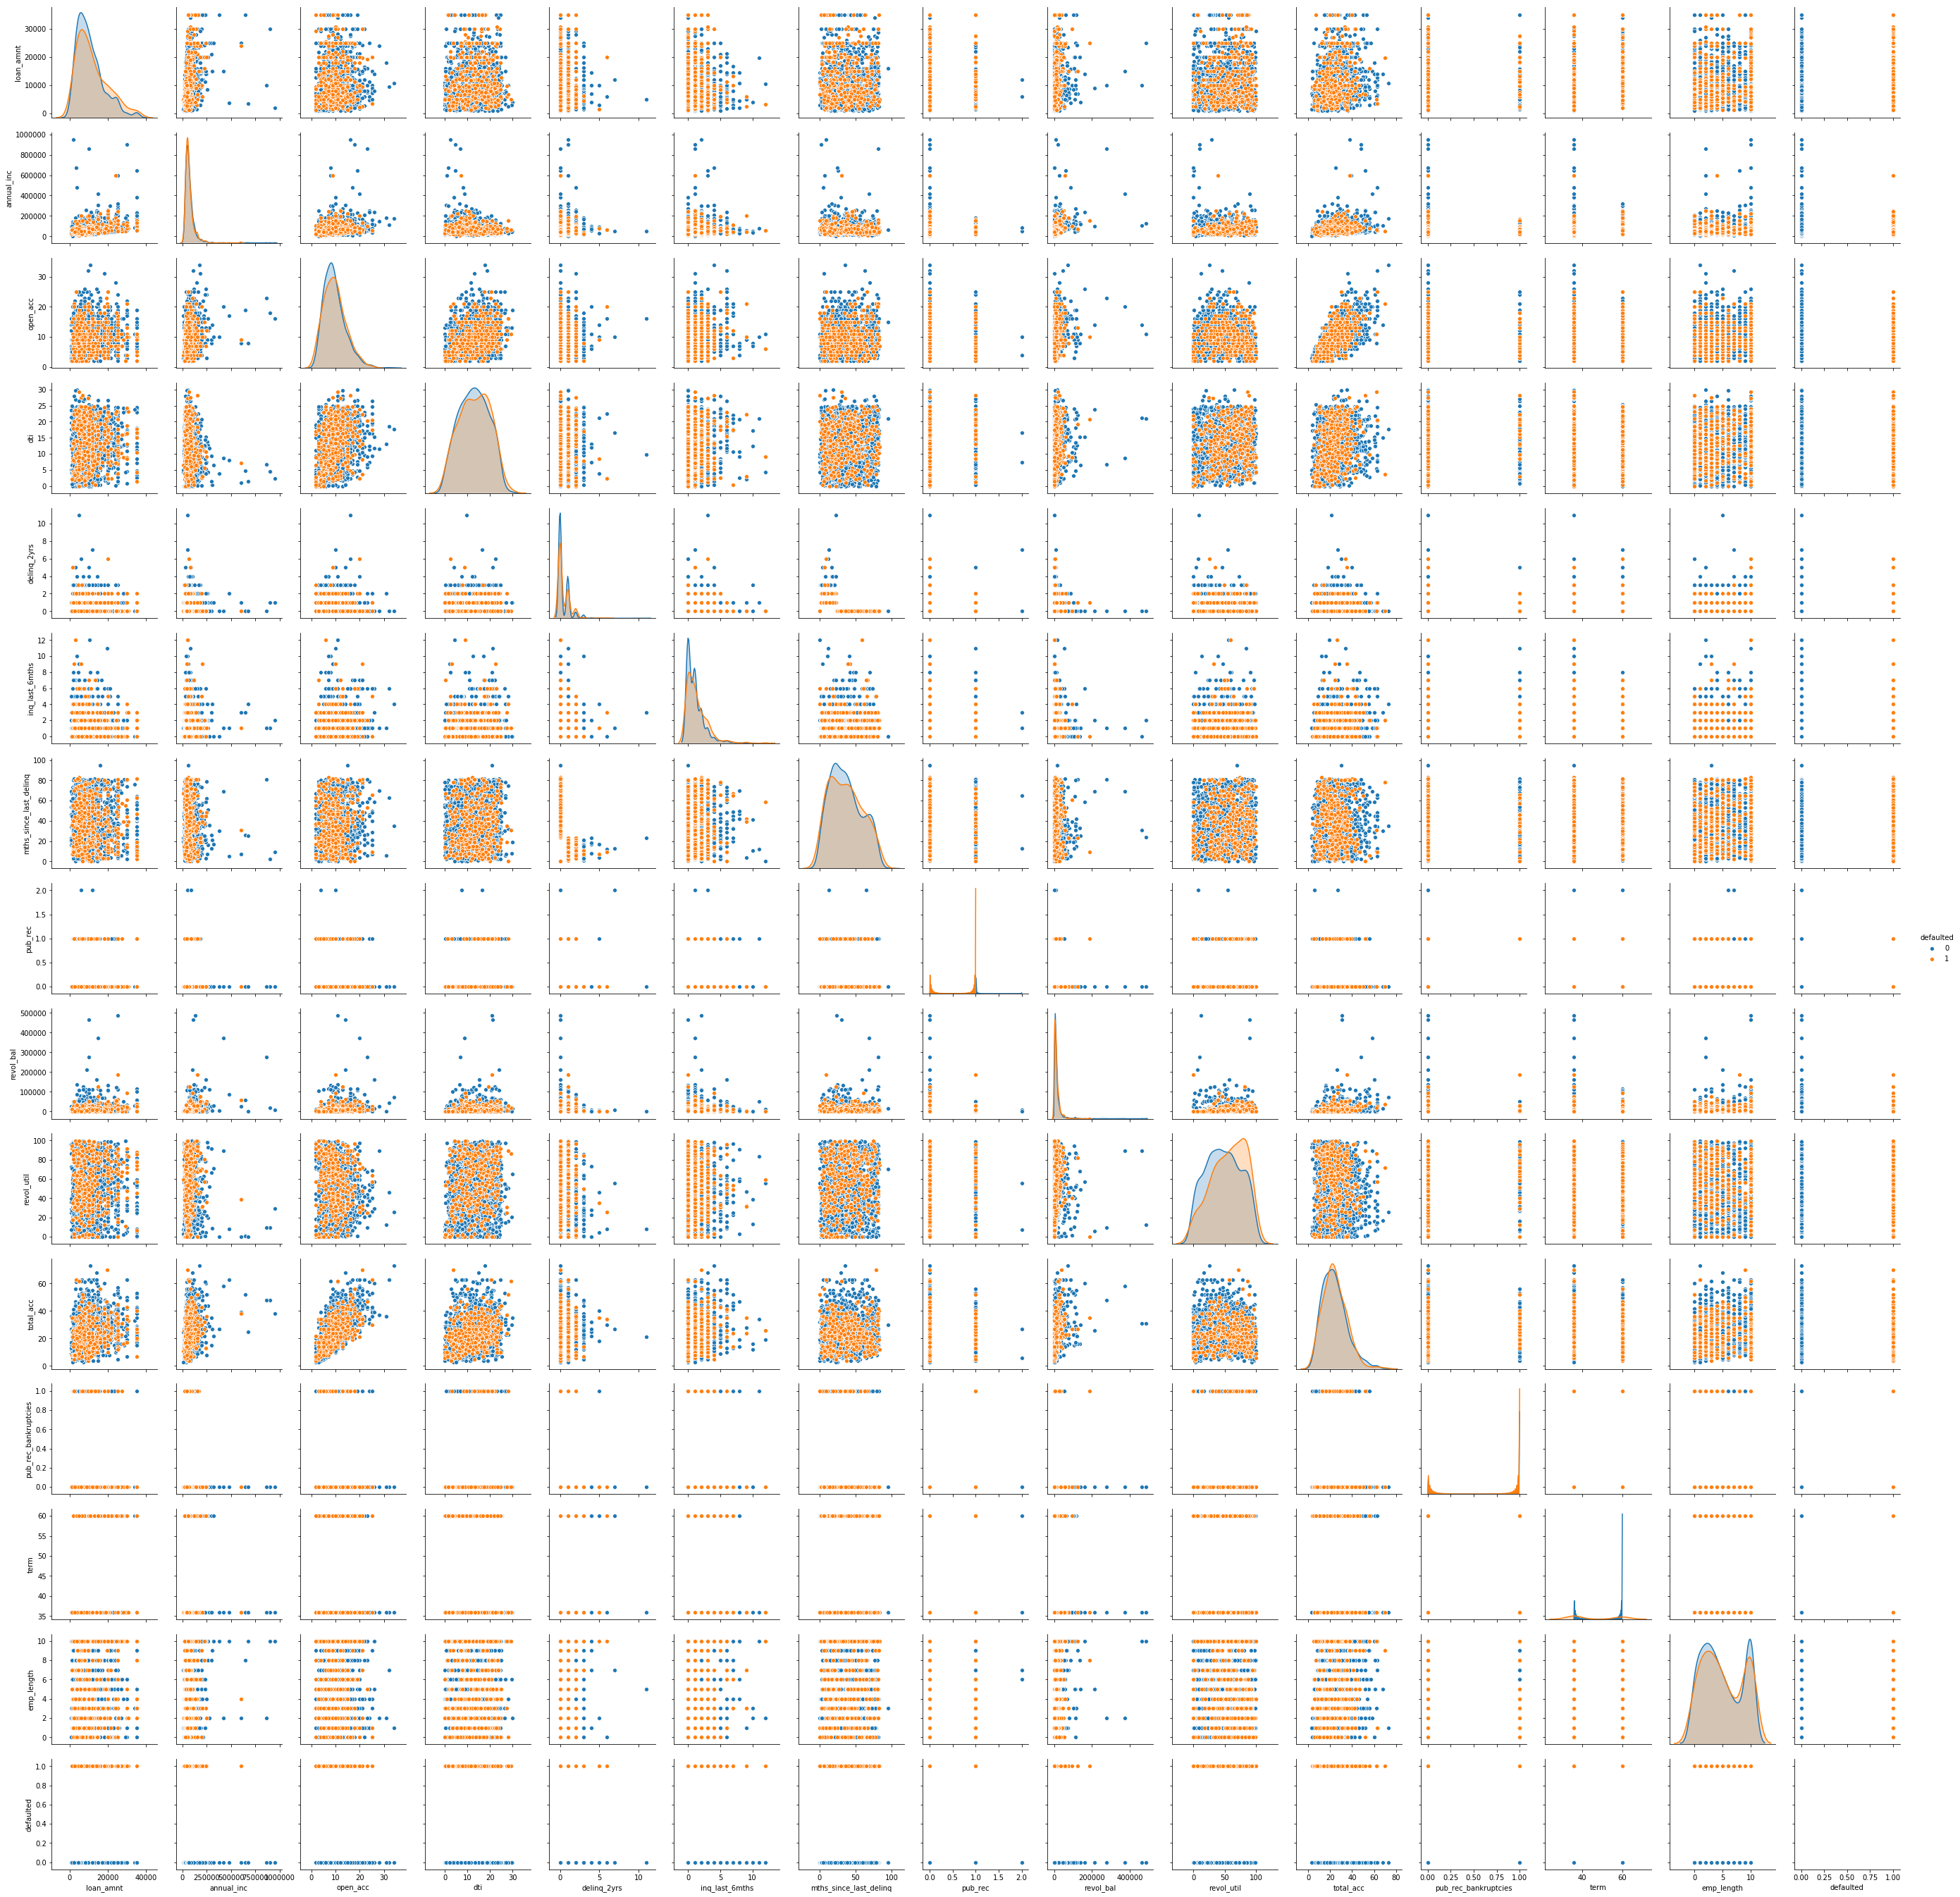

In [0]:
X_train, X_test, y_train, y_test = train_test_split(loan_data.drop('defaulted', axis=1), 
                                                    loan_data['defaulted'], random_state=42)

eda_set = X_train.sample(2000, random_state=42)
eda_set['defaulted'] = y_train[X_train.index]

sns.pairplot(eda_set, hue='defaulted')

In [0]:
#  Are there significantly skewed colums?
eda_set.skew().sort_values()

revol_util                -0.039553
dti                       -0.011717
emp_length                 0.215982
mths_since_last_delinq     0.338789
total_acc                  0.824652
open_acc                   0.960086
loan_amnt                  1.137421
term                       1.158652
defaulted                  1.851176
inq_last_6mths             2.346397
delinq_2yrs                3.391686
pub_rec                    3.431970
pub_rec_bankruptcies       3.971368
annual_inc                 6.837527
revol_bal                 10.076598
dtype: float64

Yes, it seems that `inq_last_6mths`, `delinq_2yrs`, `annual_inc` and `revol_bal` are all highly skewed. The `pub_rec` and `pub_rec_bankruptcies` are almost binary, so we will convert them. There only seem to be 5 year and 3 year loans to, so we will convert those to a binary-like feature.

In [0]:
def binarize(series):
  return (series > 1).astype(int)

# make_column_transfomer is a helper function
# to make a pipeline that only operates on some columns
process_numeric = make_column_transformer(
    (FunctionTransformer(binarize, validate=False), ['pub_rec', 'pub_rec_bankruptcies']),
    (FunctionTransformer(np.log1p, validate=False), ['inq_last_6mths', 'delinq_2yrs', 'annual_inc', 'revol_bal']),
    (StandardScaler(), ['revol_util', 'dti', 'emp_length', 'mths_since_last_delinq', 'total_acc', 'open_acc', 'loan_amnt', 'term']),
    remainder='passthrough'  # must have this, otherwise all the non-tranformed (i.e. categorical) features will be dropped!
)

preprocess_pipeline = Pipeline([
    ('transform_categorical', categorical_pipeline),
    ('transform_numeric', process_numeric),
])

# We can fit this, but there is not (currently) a nice way of getting the feature
# names back again. There is a PR that addresses this, and work is ongoing:
# https://github.com/scikit-learn/scikit-learn/issues/6425
preprocess_pipeline.fit_transform(eda_set, eda_set.defaulted)[:3, :]


array([[ 0.        ,  0.        ,  1.09861229,  0.        , 11.08215793,
         9.89842476, -0.46792527, -1.74332456, -1.4117904 ,  0.33730583,
         0.61682131,  0.74214072,  0.2116148 , -0.57658047,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.13805834,
         0.        ],
       [ 0.        ,  0.        ,  0.69314718,  1.38629436, 11.15626481,
         8.09437844, -1.0251254 , -1.11872987, -1.4117904 , -0.91231784,
         2.05778216,  1.18573947, -1.09852276, -0.57658047,  2.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.15838773,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 12.28303832,
        10.65645903,  0.4981295 , -0.14183915,  1.41971863,  0.19845875,
         1.6074819 ,  1.62933823,  1.24593392, -0.57658047,  2.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.15838773,
         0.        ]])

In [0]:
# How many features do we have?
preprocess_pipeline.fit_transform(eda_set, eda_set.defaulted).shape

(2000, 21)

Recall that `eda_set` also has the target column appended. The order of the columns is the order they first appeared in the `numeric_pipeline` (the last thing applied), then the order they appeared in the original dataframe after being transformed by the categorical pipeline. So our order is

In [0]:
feature_order = ['pub_rec_BIN', 'pub_rec_banruptcies_BIN', 'inq_last_6mnths_LOG', 'deliq_2yrs_LOG',
                'annual_inc_LOG', 'revol_bal_LOG', 'revol_util_SS', 'dti_SS', 'emp_length_SS',
                'mths_since_last_deliq_SS', 'total_acc_SS', 'open_acc_SS', 'loan_amnt_SS', 'term_SS',
                'grade', 'RENT', 'MORTGAGE', 'OTHER', 'OWN', 'purpose']

# Note this isn't necessary, we can do all our ML on numpy arrays, but this does help debug.
# The github issue above talks about implementing a `get_feature_names()` on ColumnTransformer
# that will prevent us from having to do this manual work

# We could pass our output to a DataFrame is we wanted to view the columns in a nicely 
# formatted way as follows:
pd.DataFrame(preprocess_pipeline.fit_transform(eda_set, eda_set.defaulted),
            columns = feature_order + ['defaulted']).T  # The "Transpose" makes it easier to see all the names

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
pub_rec_BIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pub_rec_banruptcies_BIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
inq_last_6mnths_LOG,1.098612,0.693147,0.000000,0.000000,0.000000,0.693147,1.386294,0.693147,0.000000,1.386294,1.386294,0.000000,0.693147,1.386294,0.000000,0.693147,0.693147,0.000000,0.000000,1.791759,0.000000,0.000000,0.000000,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,1.098612,0.693147,1.386294,1.098612,1.098612,0.000000,1.098612,...,0.000000,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,0.000000,1.098612,0.000000,0.693147,2.197225,0.693147,0.693147,0.000000,1.609438,0.000000,0.693147,0.000000,0.693147,0.000000,0.693147,1.386294,0.000000,0.693147,0.000000,0.000000,0.693147,1.098612,0.693147,0.000000,1.098612,1.791759,0.000000,0.693147,0.000000,1.098612
deliq_2yrs_LOG,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,1.098612,0.000000,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,0.693147,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.386294,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.098612,0.000000
annual_inc_LOG,11.082158,11.156265,12.283038,11.097425,11.211834,11.008761,13.304687,10.434145,11.002117,10.819798,11.156265,10.714440,11.849405,9.798183,10.736331,10.834194,11.452039,11.608245,10.925237,10.915107,10.896758,10.859018,11.156265,11.002117,13.381648,11.302217,11.884496,11.491916,10.896758,12.100718,11.350418,11.082158,11.002117,11.695255,10.985310,10.942014,11.177467,11.598745,11.264477,11.695255,...,11.289844,10.714440,11.159801,11.512935,11.077594,10.404293,11.002117,11.277216,10.308986,11.373043,10.911318,11.289844,11.982935,11.002117,11.066591,11.198228,10.596860,10.221978,10.809748,11.211834,11.561725,11.751950,10.668979,11.097425,11.695255,11.918397,11.856522,10.778977,10.926136,11.082219,

If we had too many features so that we worried about overfitting, it can also be useful to look and see which features are highly correlated. 

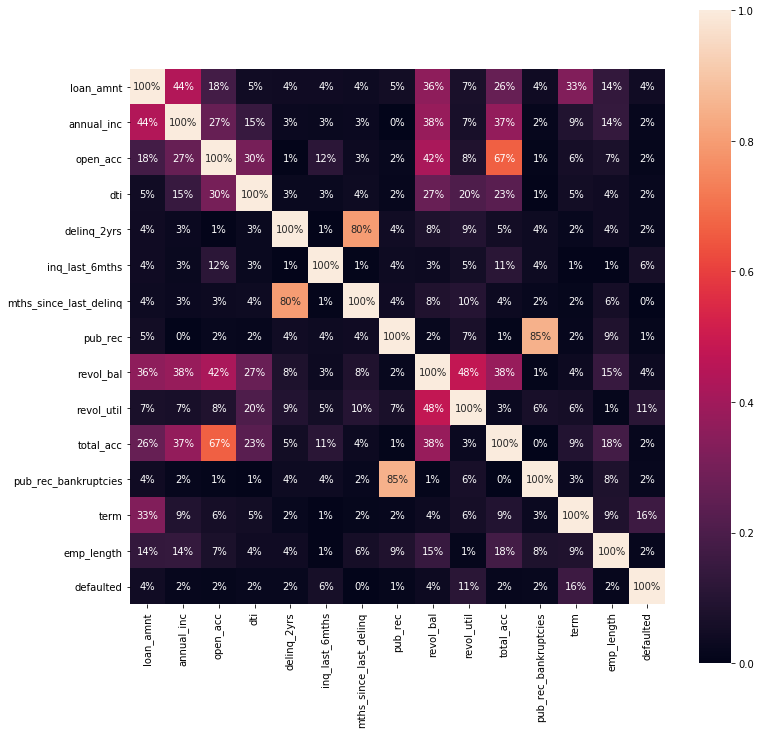

In [0]:
plt.figure(figsize=(12,12))
sns.heatmap(abs(eda_set.corr(method='spearman')), square=True, annot=True, fmt='.0%');

## Make a model

We are just going to make a quick random forest model:

In [0]:
# define the pipeline
# for a random forest, we do need the categorical pipeline transformations
# Technically we don't need the skewing and scaling, but it doesn't hurt
# to use it, and makes it easy to adjust to, say, a LogsticRegression or 
# SVM later where it does matter.
rf_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('forest', RandomForestClassifier())
])

# We access the "forest" stage by placing forest__ at the beginning of the 
# parameter we want to scan over
params = {
    'forest__n_estimators': [200],
    'forest__random_state': [42],
    'forest__max_depth': [4, 6, 10],
    'forest__class_weight': [{0:1, 1:3}, 'balanced', {0:1, 1:5}, {0:1, 1:10}]
}

grid = GridSearchCV(rf_pipeline, param_grid=params, cv=5, scoring='f1').fit(X_train, y_train)

In [0]:
imbalance_in_train = np.mean(y_train)
train_accuracy = (grid.predict(X_train) == y_train).mean()
train_recall = recall_score(y_train, grid.predict(X_train))

print(f"""
The accuracy of the best model was {train_accuracy:.1%}, while the recall was {train_recall:.1%}
The training data was {imbalance_in_train:.1%} defaults.
Guessing the majority class would get {max(imbalance_in_train, 1-imbalance_in_train):.1%} accuracy (but 0% recall)
""")


The accuracy of the best model was 69.3%, while the recall was 62.7%
The training data was 16.3% defaults.
Guessing the majority class would get 83.7% accuracy (but 0% recall)



We can change the _threshold_ to improve precision/accuracy, at the cost of recall. 

In essence, the problem that we have is that the defaults are rare (~16% of the data). We would be more accuate simply guessing that no one would ever default, but that would give us a lot of bad loans approved. Instead, we can prioritize recall, which asks what fraction of bad loans did we flag. 

It may seem that flagging only 63% of bad loans is still too low. We can access the `predict_proba` method to get the probability that the loan will be bad, and make a decision based on that. This is what scikit-learn does "under the hood", but it decides to say the loan is bad if the probability is more than 50% (and good otherwise). We can choose to be a little more aggressive in flagging bad loans:

In [0]:
prob_default_predicted = grid.predict_proba(X_train)[:, 1]

# Let's flag loans with a probability of being bad > 40% instead
THRESHOLD = 0.4
y_predict = (prob_default_predicted > 0.4)
print(f"""
Using a probability threshold of {THRESHOLD:.0%}, our recall score is {recall_score(y_train, y_predict):.1%}
""")



Using a probability threshold of 40%, our recall score is 90.2%



## .. but that probability isn't a probability

It turns out that it is a little misleading to think of `predict_proba` as a literal probability. It is better to think about it as a score, from 0 to 1, indicating how confident our model is.

Let's look at the distribution of probabilities our model gives:

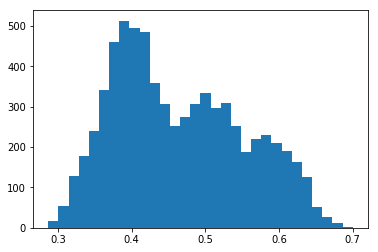

In [0]:
plt.hist(prob_default_predicted, bins=30);

We see that all our probabiltiies are in the roughly 30% - 70% range.

Let's ask the following question:
> What percentage of the time are the loans with probability 38% - 42% of being bad actually bad?

If the probabilities were _true_ probabilities, we would expect the answer to be somewhere between 38% and 42%. Let's see what the actual number is:

In [0]:
mask_probability = (prob_default_predicted < 0.42) & (prob_default_predicted > 0.38)

# let's look at the fraction of TRUE answers out of this set that were actual 
# defaults:
y_train[mask_probability].mean()

0.0873452544704264

Wow! Only 8% of the loans that had a ~40% probability (according to our model) of defaulting actually defaulted! Our model is vastly overestimating the probability of default for these customers. 

Let's look around 60%:

In [0]:
mask_probability = (prob_default_predicted < 0.62) & (prob_default_predicted > 0.58)
y_train[mask_probability].mean()

0.33931484502446985

Again, there is a huge difference!


If you are just using the probabilities as a score, this isn't a big deal. It is true that a higher value from `predict_proba` means that the model is more confident in its assessment that the person will default. If you are using these as _probabilities_ by using the output to answer questions such as "we can absorb this fraction of defaults" the results are disasterously bad!

The problem has been accentuated here because when training the grid search, I emphasized recall score (and changed the weighting of the classes), but even in a balanced problem with no class reweighting, ensemble learners tend to cluster around the middle probabilities. This is because we are clustering weak learners, each of which can have low accuracy, but high accuracy in aggregate. However, the probabilities are the fraction of weak learners that make a particular prediction, so this is closer to 50% (or, 1/n_classes) than a normal probability would be.

So far I have shown this effect by manually binning the predictions and looking at the result. There is a more automated way of doing this, called the _calibration curve_, which is built into scikit learn:

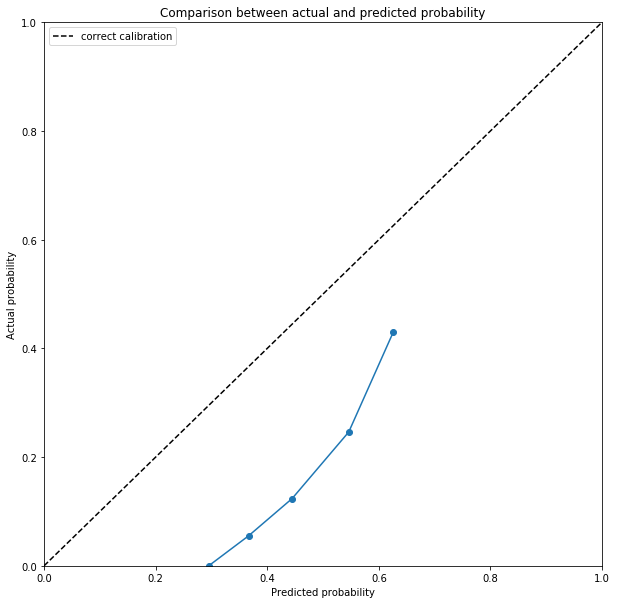

In [0]:
# Note that n_bins here is only an upper limit; calibration_curve may decide it 
# doesn't have enough points / different values to create the number of bins 
# requested
prob_true, prob_predicted = calibration_curve(y_train, prob_default_predicted, 
                                              n_bins=10)

plt.figure(figsize=(10,10))
plt.plot(prob_predicted, prob_true, '-o')
plt.plot([0, 1], [0, 1], 'k--', label='correct calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Actual probability')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Comparison between actual and predicted probability');

**Technical note:**

As a side note, this idea of probability calibration side-steps what the "true" probability should be. Some models do a good job (i.e. are able to give probabilities close to 0 or close to 1, i.e. they are very sure about most of their cases). In this case, we note that no bin every has an "actual" probability over ~40%. A better classifier would have bins with "actual" probabilities closer to 1.

Here "actual probability" is defined by "% of times that our _model_ assigned similar instances a probability within the same bin" i.e. we are making the grouping based on the _outputs_. This is different from the normal frequentist approach, which looks repeats of identical -- or "similar" -- inputs, but runs into problems when you have to decide how similar the inputs have to be to be counted together.

## Platt scaling

At this point, we could
* make a mapping, so we know that when our model says 30% probability, that really means$\approx$ 0% probability; 35% from the model means 10% in reality, .....
* use a technique called _Platt scaling_ to model this for us.

It is possible to calibrate on already fit models (like the one we have) but we should keep the calibration data separate so as to not overfit the probabilities. We will retrain our model, but using the parameters we already found were optimal

In [0]:
grid.best_params_

{'forest__class_weight': {0: 1, 1: 5},
 'forest__max_depth': 4,
 'forest__n_estimators': 200,
 'forest__random_state': 42}

Let's create a new pipeline that includes the calibration step:

In [0]:
# CalibratedClassifierCV is currently written to check the inputs to fit are all
# finite, numeric, and not missing BEFORE passing to the estimator, so we have to
# do the preprocessing first.
#
# Presumably this will change as the Pipelines and ColumnTransformers become more
# standard approaches!
#
# For the moment, we will make a new pipeline that includes the calibration.
# 
# This is also why it is nice to "group" operations into their own pipelines, 
# as it allows up to repurpose groups of steps when we have to change something
# in our later flow.

calibrated_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('calibrated_forest', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=200, max_depth=4,
                               class_weight={0: 1, 1:5}),
        method='sigmoid', cv=5))
])

calibrated_pipeline.fit(X_train, y_train);

This is a little convoluted, as the RandomForest is being used _inside_ the Calibration. This shows you how to use it, if you want to dig in more, a simple step-by-step example can be found in [this article](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html).

Once we have trained this pipeline, we can get probabilties for defaulting in the usual way:

In [0]:
prob_calibrated = calibrated_pipeline.predict_proba(X_train)[:, 1]
prob_calibrated[:5]

array([0.2589813 , 0.11280595, 0.17281725, 0.10319541, 0.05245852])

Let's replot the calibration curve and see what happened:

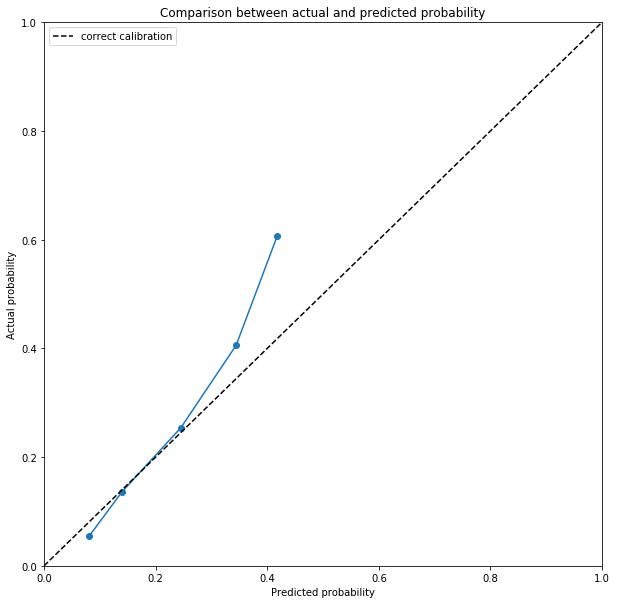

In [0]:
prob_true, prob_predicted = calibration_curve(y_train, prob_calibrated, 
                                              n_bins=10)

plt.figure(figsize=(10,10))
plt.plot(prob_predicted, prob_true, '-o')
plt.plot([0, 1], [0, 1], 'k--', label='correct calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Actual probability')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Comparison between actual and predicted probability');

We see that the calibration isn't perfect, but has gone a long way toward making sure the probabilities we get are interpretable as probabilities.

## Summary

* ColumnTransformations are coming to sklearn, which allow us to do certain transformations to certain features. No more doing standard scaling to everything.

* There are multiple ways of converting non-numeric features into numeric features. For ordered features, the `OrdinalEncoder` is a good choice. If the features are unordered, we explored `OneHotEncoder` (suitable for few levels) and `JamesSteinEncoder` (suitable for many levels). There are other encoding schemes, such as Feature Hashing, that we _didn't_ discuss.

* `category_encoders` is a package that makes working with different encoders easier.

* We are moving toward pipelines to make the processing easier and more robust, but there are still some rough edges with extracting the feature names (that will hopefully be fixed soon).

* The name `predict_proba` on many of the  scikit-learn estimators is highly misleading. 
  * If you just want a score or measure of confidence, `predict_proba` output is fine. Higher scores mean more confidence.
  * If you actually try to interpret the results as a probability (e.g. putting into analytics, or using expected values) you should calibrate the probabilities first.

# Some references

1. [Calibration curves blog post](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html), and scikit-learn [user guide](https://scikit-learn.org/stable/modules/calibration.html).
2. [ColumnTransformer blog post](https://kiwidamien.github.io/introducing-the-column-transformer.html)


# Extra problem: Predicting the Median House Price

_Problem_
Given features of a neighborhood, find the median house price in that neighborhood

_Usage_
Decide which region to expand into

_Metric_
Use (root) mean squared error, so as to penalize outliers more. 

_Alternative metrics_
We might also consider using a skewed metric that penalizes us more for having a prediction that is too high vs one that it too low. Consider the consequences of making an error: 
  - **Estimate is too low:** We might miss an opportunity to get into a good area
  - **Estimate is too high:** We over value houses in an area, and pay too much for them, leaving us with expensive houses.
  
Both are bad, but generally we want to punish the second one more.

Let's start by looking at the dataset

In [0]:

dataset = california_housing.fetch_california_housing()
dataset.keys()

Let's read what is in the description:

In [0]:
print(dataset['DESCR'])

Some important points to note here:
- the target variable is the _median_ house price on a block, not an individual house price.
- different blocks have different populations (and therefore different number of houses)

We expect that on blocks with fewer houses that we can have more variation in price, as it is easier to get three unusually high priced houses in a clump than 30 unusually high priced houses. We will address this by looking at the different _weights_ we can apply to the 

In [0]:

features = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
target = pd.Series(dataset['target'])
full_dataset = features.copy()
full_dataset['target'] = target
features.head()

How many individual points do we have in this dataset?

In [0]:
full_dataset.shape

20k individual blocks with only 9 features leaves us with a _lot_ of data. We probably don't need to eliminate many features.

When starting our initial investigation, we start by subsampling the points. Pair plots with too many points are difficult to read beacuse of overplotting. I also set a random state to ensure that the results are reproducible for someone reviewing my code. 

We are picking points that are (hopefully) a _representative_ sample of the population. The biggest thing we would expect to vary from run-to-run is our assessment of outliers, which are rare by definition. Without a random state set, the most extreme value in each feature will set the scale, which could vary a lot from run to run. This also means that we have to be careful when making conclusions about outliers from this sample


---

 Outliers are not robust and will vary a lot from sample to sample, even if the samples are large


  
---


## EDA

Let's start by splitting our data into a train and test set. We will further subsample the training set into a smaller EDA set. The EDA set does two things:

1. Allows us to avoid overplotting when exploring the data (e.g. with pair plots). If we have too many points, it can be difficult to pick out the dense regions
2. Allows us to have a little more confidence in our CV results, because we haven't looked at the entire dataset when doing our EDA.

The second point is more a point of principle -- if we make decisions looking at the entire training set, then information is "leaking" when we do cross-validation because we made decisions based on what we saw from the hold out fold (during EDA). In practice, this type of leakage isn't particularly troublesome.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, target)
eda_set = X_train.sample(2000, random_state=52)
eda_set['target'] = y_train[X_train.index]

Let's do our EDA on the 200 points we held out. We will start by looking at the pair plot distribution:

In [0]:
sns.pairplot(eda_set, plot_kws={'alpha': 0.3})

The first thing we notice is that we have some extreme outliers. We also see some heavily skewed features, such as `AveRooms`,  `Population`, `AveOccupancy` and `MedInc`. First, let's eliminate outliers. We are going to do this part "by eye" (i.e. using heuristics and checking them, rather than doing fancy ML models).

To start, note that most of the outliers are at high values (i.e. our feautures are _positively skewed_). We will look at cutting off results past a certain percentile.

**Note** 

Skewness is often counter-intuitive (at least to me). Positively skewed has the mean to the right (i.e. more positive) than the median. This means the data has to be pushed to the _left_ (i.e. more negative). So if the data has a big lump on the _left_ side, it is _positiviely_ skewed.

$$\text{skew} = E\left[\left(\frac{\text{data}-\text{mean}}{\sigma}\right)^3\right] = \frac{3(\text{mean}- \text{median})}{\sigma} + \ldots$$

In [0]:
def plot_series_and_quantiles(series, quantiles=[0.9, 0.95, 0.99]):
  """Plot a histogram of series and marks the quantiles
  
  series: pandas series
          data to plot and measure quantiles of
  quantiles: iterable of floats between 0 and 1
          quantiles of the data to make cuts on
  """
  cuts = series.quantile(quantiles)
  plt.hist(series, bins=50);
  for index, value in cuts.iteritems():
    label=f'{index:.1%} ({value:.1f})'
    plt.gca().axvline(value, color='k', ls='--', label=label)
  plt.legend()

plt.figure(figsize=(10,8))
plot_series_and_quantiles(eda_set['AveRooms'])

i.e. it seems we can lose 1% of our data by eliminating all blocks with an average number of rooms in a house greater than 10.

It is also quite likely that some of the other outliers were these "many roomed houses". Let's have a look at our pair plot after eliminating these outliers.

In [0]:
sns.pairplot(eda_set[eda_set['AveRooms'] < 10], plot_kws={'alpha': 0.3})

We still see some outliers, especially with Average Occupancy, but it is a lot more controlled now. With these points eliminated, let's look for highly skewed features:

In [0]:
feature_skew = eda_set.drop('target', axis=1).skew()
feature_skew

We will see in the next step how we will use the skew to determine how to preprocess the features.

## Preprocesing

For all the features that have skew greater than 1, we will take the log of the feature to more evenly distribute it (and give our models a "better chance" of finding value in the feature). For the non-logged features, we will apply standard scaling.

Different types of transformations on different parameters used to be a nuicence. The _ColumnTransformer_ has made this a lot easier. It allows us to perform different transformations on the data in a way that is respected by cross-validation.

To see how preprocessing and standard scaler (for example) interact, consider what it means to scale a feature. It means we take the original values of the feature $X_i$ and replace them with
$$\text{scaled version of feature} = \frac{X_i - \bar{X}}{s}$$
where $\bar{X}$ and $s$ are the sample mean and standard deviation of the feature.

If we perform this at the _beginning_ of our preprocessing on the entire training set, $\bar{X}$ and $s$ are the mean and standard deviation of the entire training set. When doing CV, the scaled features have some information about the hold out set, undermining our ability to trust how well CV generalizes to the hold-out set.

ColumnTransformers are "CrossValidation Friendly", and will re-process the data during cross-validation without access to the holdout set.


**Note:**

Technically the issue of data leakage doesn't apply to log transforming a feature, because we only use the value in a specifc row. However, we show how to apply the logging step as part of the ColumnTransformer steps, in case you wanted to implement your own

In [0]:
to_skew = (feature_skew > 1.0)
skew_features = feature_skew[to_skew].index.values
scale_features = feature_skew[~to_skew].index.values

msg=f"""
Features that we are skewing: {skew_features}
Features that we are scaling: {scale_features}
"""
print(msg)

def calc_num_houses(df):
  house_num = df['Population']/df['AveOccup']
  sqrt_house_num = np.sqrt(house_num)
  return np.stack([house_num, sqrt_house_num], axis=1)

# The steps (Transformer, feature_list) applies the Transformer
# but only to the columns in feature_list

add_feature = FeatureUnion([
    ('log_features', make_column_transformer((FunctionTransformer(np.log1p, validate=False), skew_features))),
    ('scale_features', make_column_transformer((StandardScaler(), ['HouseAge', 'Latitude', 'Longitude']))),
    ('add_houses', FunctionTransformer(calc_num_houses, validate=False))
])

eda_transformed = add_feature.fit_transform(eda_set)
sns.pairplot(pd.DataFrame(eda_transformed, columns=list(skew_features) + 
                          list(scale_features)+['num_houses', 'sqrt_houses']))


## Model fitting

Let's start by fitting a relatively simple model (regularized linear regression) to this dataset. We will start without cross-validation, just to see how pipelines work.

In [0]:
# Throw out the outliers (still tricky to put into a pipeline)
# Can use imbalancedlearn's extension to pipelines.
# See http://imbalanced-learn.org/en/stable/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline
inliers = (X_train['AveRooms'] < 10)

# Build a model.
# A pipeline consists of a series of steps
#   A step is (name, transformer), where name is for us to refer to
#   A tranformer is either a pipeline (such as preprocess)
#                          a transformer (e.g. StandardScaler)
#                          or an estimator (e.g. Ridge)
# This pipeline takes data, applies the preprocess pipeline and THEN 
#      applies Ridge
ridge_model = Pipeline([
    ('preprocessing', add_feature),
    ('ridge_estimator', Ridge(alpha=3))
])

# Train the model, only looking at the "inliers"
# i.e. don't let the outliers modify the fit.
ridge_model.fit(X_train[inliers], y_train[inliers])

# Score on all training points (including the outliers)
print(f"""
Score on the training data (remove outliers): {ridge_model.score(X_train[inliers], y_train[inliers])}
Score on the training data (including outliers): {ridge_model.score(X_train, y_train)}
""")

We could have done this without having a preprocessing step separately. Where this really comes in useful is when we do cross-validation, because now the preprocessing is `fit` and applied on each fold.

**Reminder**
When doing `StandardScaler`, we `fit` on the training set (i.e. get mean and standard deviation) and then `transform` on the test set (which uses the _training_ mean and standard deviation to transform the test set).

Cross-validation calls `fit` on the "training" folds, and `transform` on the hold-out fold, giving us the same effect.

In [0]:
# We can access parameters in a pipeline using
# name__parameter.
# To alter the alpha value of the 'ridge_estimator' step
# in a pipeline, we can change 'ridge_estimator__alpha'
# in the parameter dictionary passed to grid search cv
params = {
    'ridge_estimator__alpha': np.logspace(-4, 6, 30)
}

# build the grid seach using our pipeline and the 
# parameter set defined above
grid_model = GridSearchCV(ridge_model, param_grid=params, cv=5)

# Train on the inliers. The pipeline makes sure 
# we scale the feature correctly (yay!)
grid_model.fit(X_train[inliers], y_train[inliers])

print(f"""
Score on the training data (remove outliers): {grid_model.score(X_train[inliers], y_train[inliers])}
Score on the training data (including outliers): {grid_model.score(X_train, y_train)}
""")

We see that cross validation did _slightly_ worse once outliers were included, but performed (again _slightly_) better when scored on the data seen during training. 

In [0]:
grid_model.best_params_

## Effect of sample size

We have completely ignored the number of houses on a block. 

At the beginning, we mentioned that the more houses we sampled, the more confident we are in the median house price. Put another way, we expect more variation in our statistics as we look at smaller sample sizes. 

We can see this expliciltly by looking at how the residual (our error) changes with the number of houses in that block.

In [0]:
residuals = y_train - np.clip(grid_model.predict(X_train), 0, 5)
num_houses = X_train['Population']/ X_train['AveOccup']

In [0]:
plt.figure(figsize=(12,10))
plt.plot(num_houses, residuals, 'o', alpha=0.3)
plt.xlabel('Number of Houses in Sample')
plt.ylabel('Residual')
plt.title('How error changes with number of samples');

We expect to do more poorly on small sample size because statistical fluctuations have more noise. 

There are some other excellent examples discussed by [Cameron Davidson-Pilon](https://www.slideshare.net/PyData/mistakes-ive-made-cam-davidsonpilon) with census mail-ins, [Ben Jones](https://dataremixed.com/2015/01/avoiding-data-pitfalls-part-2/) with discussions on Kidney Cancer rates,  [five thirty eight]() with boardgame popularity

![Census mail-in rates](https://image.slidesharecdn.com/decks-150806163451-lva1-app6891/95/mistakes-ive-made-cam-davidsonpilon-17-638.jpg?cb=1438879035)

![https://fivethirtyeight.com/wp-content/uploads/2015/01/roeder-worstgames-1.png?w=575](https://fivethirtyeight.com/wp-content/uploads/2015/01/roeder-worstgames-1.png?w=575)


At the moment, if we have 1000 houses spread into 100 blocks with 10 houses each, that will contribute 100 data points  to the plot above. A neighborhood with 1000 houses will contribute just one point. 

Ridge Regression tries to fit each row equally, so each of the 100 poorly measured blocks will be just as influencial on the parameters as one (well measured) block with 1000 houses. 

While the statistical fluctations of the 100 small blocks should cancel, we should tell Ridge Regression we are more confident about the block with 1000 houses by giving it more _weight_.

Assuming the main source of noise is statistical, we should weigh the blocks with more houses more.

### How much weight should points get?

The median (or any quartile) follow a  [theorem](https://en.wikipedia.org/wiki/Delta_method) similar to the central limit theorem for samples, namely
> The distribution of medians of samples of size $N$ in a population follow a normal distribution, where the average value is the population median, and the standard error scales as $1/\sqrt{N}$

In sklearn, the weight should be inversely proportional the error estimatee (i.e. if we have half the uncertainty in a point, we should give it twice the weight). We will weigh our points with a weight $\sqrt{N}$, where $N$ is the number of houses on that block

In [0]:
# takes longer to describe than to do:
inliers_remove_small = inliers

grid_model_w = GridSearchCV(ridge_model, param_grid=params, cv=5)
grid_model_w.fit(X_train[inliers_remove_small], y_train[inliers_remove_small], 
               ridge_estimator__sample_weight=np.sqrt(num_houses[inliers_remove_small]));

print(f"""
Score on the training data (remove outliers): {grid_model_w.score(X_train[inliers_remove_small], y_train[inliers_remove_small])}
Score on the training data (including outliers): {grid_model_w.score(X_train, y_train)}
Score on the test data: {grid_model_w.score(X_test, y_test)} (weighted) {grid_model.score(X_test, y_test)} (unweighted)
""")

In [0]:
residuals = y_train - grid_model.predict(X_train)
new_residuals = y_train - grid_model_w.predict(X_train)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.plot(num_houses, residuals, 'o', alpha=0.2)
plt.xlabel('Number of Houses in Sample')
plt.ylabel('Residual')
plt.title('How error changes with number of samples (unweighted)');

plt.subplot(122)
plt.plot(num_houses, new_residuals, 'o', alpha=0.2)
plt.xlabel('Number of Houses in Sample')
plt.ylabel('Residual')
plt.title('How error changes with number of samples (weighted)');


In [0]:
param_tree = {
    'n_estimators': [100],
    'min_samples_split': [4],
    'random_state': [52]
}

rfr = GridSearchCV(RandomForestRegressor(), param_grid=param_tree, cv=3).fit(X_train, y_train)
rfr_w = GridSearchCV(RandomForestRegressor(), param_grid=param_tree, cv=3).fit(X_train, y_train, 
                                                                         sample_weight=np.sqrt(num_houses))



In [0]:
print(f"""
Training set:

Unweighted R^2 score on unweighted fit: {rfr.score(X_train, y_train)}
Unweighted R^2 score on weighted fit: {rfr_w.score(X_train, y_train)}

Test set:
Unweighted R^2 score on unweighted fit: {rfr.score(X_test, y_test)}
Unweighted R^2 score on weighted fit: {rfr_w.score(X_test, y_test)}
""")

In [0]:
sorted(zip(rfr.best_estimator_.feature_importances_, X_train.columns))

Problem persists even when I look at scoring with the weights in the scoring function.

My hope had been that putting the weights in would lead to worse scores on the training set when using naive $R^2$, but better scores on the test set/OOB set (because the weighting made the points we were more sure about more important, increasing generalizability). Instead, I am finding that even when looking at 

In [0]:
num_houses_test = X_test['Population']/X_test['AveOccup']
r2_score(y_test, rfr.predict(X_test), sample_weight=np.sqrt(num_houses_test)), r2_score(y_test, rfr_w.predict(X_test), sample_weight=np.sqrt(num_houses_test))

In [0]:
residuals = y_test - rfr.predict(X_test)
new_residuals = y_test - rfr_w.predict(X_test)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.plot(num_houses_test, residuals, 'o', alpha=0.2)
plt.xlabel('Number of Houses in Sample')
plt.ylabel('Residual')
plt.title('How error changes with number of samples (unweighted)');

plt.subplot(122)
plt.plot(num_houses_test, new_residuals, 'o', alpha=0.2)
plt.xlabel('Number of Houses in Sample')
plt.ylabel('Residual')
plt.title('How error changes with number of samples (weighted)');

In [0]:
plt.plot(num_houses_test, new_residuals- residuals,'o')
plt.gca().axhline(0)